**Overview**<br>
This notebook contains a step by step approach and detailed desciption to - <br>
i. Making Your Own Dataset from Google Images<br>
ii. Making a classifier on that dataset

First, we'll mount the google drive and write some imports and other boilerplate code.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
from pynvml import *
nvmlInit()
try:
    deviceCount = nvmlDeviceGetCount()
    for i in range(deviceCount):
        handle = nvmlDeviceGetHandleByIndex(i)
        print("Device", i, ":", nvmlDeviceGetName(handle))
except NVMLError as error:
    print(error)

Device 0 : b'Tesla T4'


In [0]:
import warnings
warnings.filterwarnings('ignore')

In [0]:
from fastai import *
from fastai.vision import *

<h2>Getting a list of URLs in csv files</h2>

**Searching the images**<br>

We'll get a list of URLs for images of a certain class and save them in a csv file. This process will have to be repeated for each class of images.<br><br>
Go to [Google Images](https://images.google.com) and search for the images you want. The more specific your search is, the better.<br>
Scroll down till you have enough images or till you have reached the end of the page.<br> Click on more images if you require more images.
For a more narrow and specialized search, you can click on Settings->Advanced Search to make a more specific query.<br>

**Downloading into a file**<br>

Once you've scrolled through all the images, you can download the urls of all the images into a csv file.<br>
Open the JavaScript console in your Chrome browser by pressing CtrlShiftJ, (in Mac press CmdOptJ ) and CtrlShiftk in FireFox.
A console opens where you'll paste this code.


```
urls=Array.from(document.querySelectorAll('.rg_i')).map(el=> el.hasAttribute('data-src')?el.getAttribute('data-src'):el.getAttribute('data-iurl'));
window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));
```





Now upload the downloaded csv files to colab in a folder bears. To have access even after the runtime ends, it's better to upload them to drive.<br>
Now, we'll download all the files from the urls to their respective folders. The folders also serve as class labels, so name them accordingly.<br><br>
fastai has a function download_images that downloads all the images from a url file to the destined folder.

In [5]:
path = Path('/content/gdrive/My Drive/')
folders = ['black','sun','polar','teddy','grizzly','panda']
classes = ['black','sun','polar','teddy','grizzly','panda']
files = ['black_bears.csv','sun_bears.csv','polar_bears.csv','teddy_bears.csv','grizzly.csv','pandas.csv']
for folder,file in zip(folders,files):
  dest = path/folder
  dest.mkdir(parents=True,exist_ok=True)
  download_images(path/file,dest)

Let's verify all images and delete those that are corrupted or can't be opened.

In [6]:
for each in folders:
  print(each)
  verify_images(path/each,delete=True)

black


sun


polar


teddy


grizzly


panda


Let's see what our dataset has.

In [7]:
for each in folders:
  print(each+':',end=' ')
  print(len((path/each).ls()))

black: 586
sun: 538
polar: 483
teddy: 320
grizzly: 518
panda: 544


Great! Now, we'll proceed with making an ImageDataBunch so that we can train our model.<br>
Since we don't have a train and validation set already, we'll have to specify this in the function.

In [8]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path,train='.',valid_pct=0.2,ds_tfms = get_transforms(),size=224).normalize(imagenet_stats)
data.classes

['black', 'grizzly', 'panda', 'polar', 'sun', 'teddy']

In [0]:
data

ImageDataBunch;

Train: LabelList (2392 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
black,black,black,black,black
Path: /content/drive/My Drive/bears;

Valid: LabelList (597 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
sun,teddy,sun,polar,black
Path: /content/drive/My Drive/bears;

Test: None

In [0]:
learn = cnn_learner(data,models.resnet50,metrics=[accuracy,error_rate])

In [17]:
learn.fit_one_cycle(8)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.866062,0.316436,0.909548,0.090452,00:31
1,0.543393,0.305722,0.906198,0.093802,00:31
2,0.424927,0.321942,0.907873,0.092127,00:31
3,0.313324,0.233092,0.927973,0.072027,00:31
4,0.257545,0.229564,0.932998,0.067002,00:31
5,0.210929,0.220821,0.929648,0.070352,00:30
6,0.160843,0.206884,0.938023,0.061977,00:30
7,0.133950,0.208951,0.938023,0.061977,00:30


Initial training gives 6.1% error. Let's see if we can do better.

In [18]:
learn.save('stage-1')
learn.unfreeze()
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


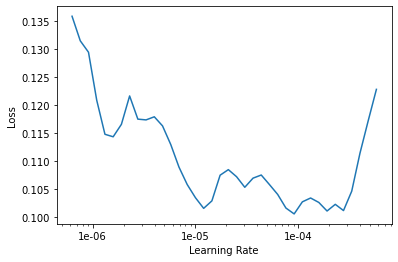

In [19]:
learn.recorder.plot()

In [20]:
# learn.load('stage-1')
learn.fit_one_cycle(7,max_lr=slice(2e-06,2e-05))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.105816,0.202435,0.941374,0.058626,00:33
1,0.111653,0.208547,0.934673,0.065327,00:33
2,0.102406,0.205775,0.936348,0.063652,00:33
3,0.088308,0.201426,0.938023,0.061977,00:33
4,0.088226,0.201170,0.938023,0.061977,00:33
5,0.087715,0.203784,0.941374,0.058626,00:33
6,0.080153,0.196771,0.943049,0.056951,00:33


A 5.6% error is definitely an improvement.

In [0]:
learn.save('stage-2')

In [22]:
interp = ClassificationInterpretation.from_learner(learn)

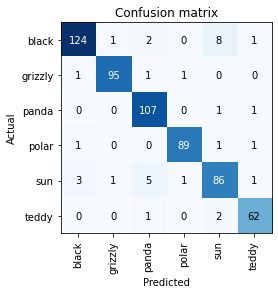

In [23]:
interp.plot_confusion_matrix()

The most confusion seems to be among sun and black bears. They are actual quite similar in images and don't have many differences.

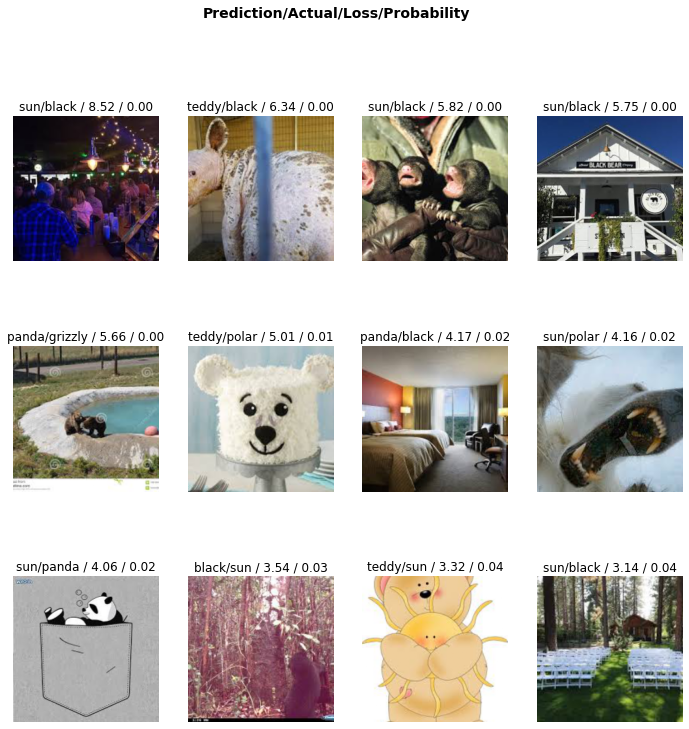

In [24]:
interp.plot_top_losses(k=12)

Clearly our dataset is quite noisy and in some cases the labels are wrong.

In [0]:
interp.most_confused()

[('black', 'sun', 7),
 ('sun', 'black', 6),
 ('sun', 'grizzly', 3),
 ('black', 'grizzly', 2),
 ('grizzly', 'sun', 2),
 ('panda', 'sun', 2),
 ('polar', 'grizzly', 2),
 ('sun', 'polar', 2),
 ('sun', 'teddy', 2),
 ('teddy', 'panda', 2),
 ('teddy', 'sun', 2),
 ('black', 'polar', 1),
 ('black', 'teddy', 1),
 ('grizzly', 'black', 1),
 ('panda', 'black', 1),
 ('polar', 'sun', 1),
 ('sun', 'panda', 1)]

<h3>Cleaning the dataset</h3>
To clean the dataset we'll make a databunch with no splits using ImageList.<br>
We'll then get the paths and ids of the images in descending order of their losses.<br>

In [0]:
from fastai.widgets import *

In [0]:
db = (ImageList.from_folder(path).split_none().label_from_folder().transform(get_transforms(),size=224).databunch())

In [27]:
db.classes

['black', 'grizzly', 'panda', 'polar', 'sun', 'teddy']

In [0]:
learn_cln = cnn_learner(db,models.resnet50,metrics=[accuracy,error_rate])

In [0]:
learn_cln.load('stage-2')

In [30]:
ds, idxs = DatasetFormatter().from_toplosses(learn_cln)

The ImageCleaner widget let's us see these images in descending order of their losses and delete them or change their labels. Since our data is really noisy, I won't take the time to clean all the images. But as you clean more images, better your accuracy gets.

In [31]:
ImageCleaner(ds,idxs,path)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

Make a new data bunch from the cleaned csv file. The images we deleted weren't deleted from the original dataset but forms a new csv file with updated levels.

In [0]:
db = (ImageList.from_csv(path, 'cleaned.csv', folder='.')
                   .split_none()
                   .label_from_df()
                   .transform(get_transforms(), size=224)
                   .databunch()
     )

In [33]:
learn_cln = cnn_learner(db,models.resnet50)
learn_cln.load('stage-2')

Learner(data=ImageDataBunch;

Train: LabelList (2978 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
black,black,black,black,black
Path: /content/gdrive/My Drive;

Valid: LabelList (0 items)
x: ImageList

y: CategoryList

Path: /content/gdrive/My Drive;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        

In [34]:
ds, idxs = DatasetFormatter().from_similars(learn_cln)

Getting activations...


Computing similarities...


In [35]:
ImageCleaner(ds,idxs,path,duplicates=True)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

In [0]:
np.random.seed(42)
data = ImageDataBunch.from_csv(path, folder=".", valid_pct=0.2, csv_labels='cleaned.csv',
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [37]:
learn = cnn_learner(data,models.resnet50,metrics=[error_rate,accuracy])
learn.fit_one_cycle(8)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.762338,0.420307,0.080808,0.919192,00:29
1,0.507994,0.449429,0.112795,0.887205,00:29
2,0.383901,0.332161,0.089226,0.910774,00:29
3,0.302258,0.289944,0.082492,0.917508,00:30
4,0.238645,0.307486,0.077441,0.922559,00:31
5,0.187552,0.302968,0.079125,0.920875,00:31
6,0.150747,0.301344,0.082492,0.917508,00:31
7,0.118072,0.304498,0.080808,0.919192,00:30


In [0]:
learn.save('stage-1-cleaned')

In [44]:
learn.unfreeze()
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


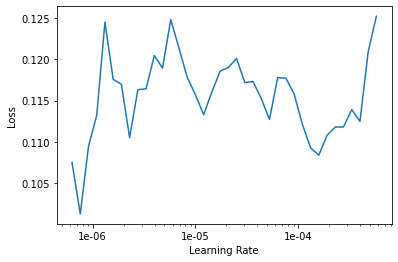

In [45]:
learn.recorder.plot()

In [46]:
learn.fit_one_cycle(7,max_lr=slice(5e-06,2e-05))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.097950,0.304709,0.082492,0.917508,00:31
1,0.106244,0.296999,0.072391,0.927609,00:31
2,0.101052,0.275410,0.067340,0.932660,00:32
3,0.086567,0.285737,0.074074,0.925926,00:31
4,0.078116,0.278327,0.069024,0.930976,00:31
5,0.072668,0.275700,0.069024,0.930976,00:32
6,0.067159,0.278862,0.069024,0.930976,00:32


In [47]:
interp= ClassificationInterpretation.from_learner(learn)

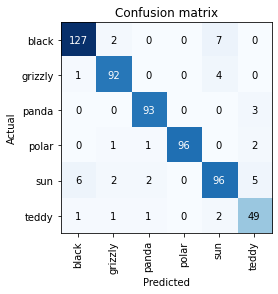

In [48]:
interp.plot_confusion_matrix()

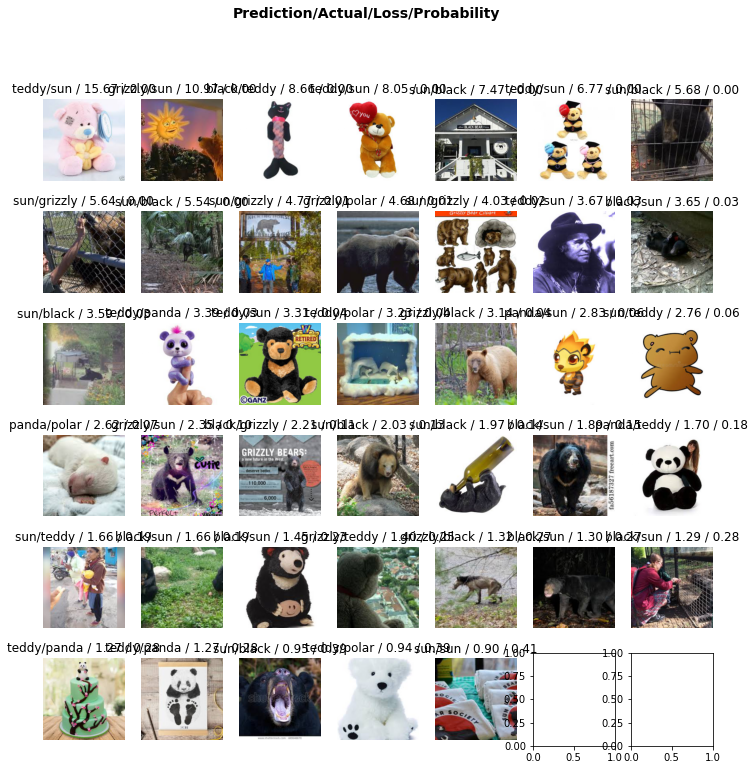

In [51]:
interp.plot_top_losses(40)

The error got a bit worse. But plotting the top losses shows us that some bears are incorrectly classified and some are not bears at all !!<br>
We can further clean the data but this notebook is only for demonstration.<br>
Cheers!!